In [1]:
import numpy as np

# first, generate the time series

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # noise
    return series[..., np.newaxis].astype(np.float32)

NameError: name 'X_valid' is not defined

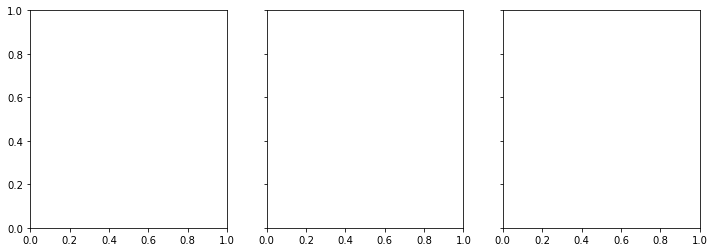

In [2]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()



In [3]:
# now create training and validation set
n_steps = 50
series = generate_time_series(10000, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
import tensorflow as tf
from tensorflow import keras

# get baseline metrics.  Here, just return the last value in each series, i.e. naive forecasting
y_pred = X_valid[:, -1] # ie just show the last value
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

# MSE is c. 0.201

0.020879796

In [5]:
# could also do a simple fully connected network - aka linear regression
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [50,1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

# MSE approx 0.04 (see below) - this is the best so far

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.2154 - val_loss: 0.0615
Epoch 2/20
219/219 [==============================] - 0s 748us/step - loss: 0.0398 - val_loss: 0.0254
Epoch 3/20
219/219 [==============================] - 0s 754us/step - loss: 0.0191 - val_loss: 0.0144
Epoch 4/20
219/219 [==============================] - 0s 742us/step - loss: 0.0123 - val_loss: 0.0105
Epoch 5/20
219/219 [==============================] - 0s 728us/step - loss: 0.0097 - val_loss: 0.0088
Epoch 6/20
219/219 [==============================] - 0s 738us/step - loss: 0.0085 - val_loss: 0.0079
Epoch 7/20
219/219 [==============================] - 0s 729us/step - loss: 0.0078 - val_loss: 0.0073
Epoch 8/20
219/219 [==============================] - 0s 738us/step - loss: 0.0072 - val_loss: 0.0068
Epoch 9/20
219/219 [==============================] - 0s 762us/step - loss: 0.0068 - val_loss: 0.0064
Epoch 10/20
219/219 [==============================] - 0s 777us/step - loss: 0.0064 

0.0041397949680686

In [6]:
# The actual RNN network:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape = [None, 1])        
])

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1633 - val_loss: 0.1007
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0583 - val_loss: 0.0295
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0180 - val_loss: 0.0129
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0112 - val_loss: 0.0113

In [8]:
model.evaluate(X_valid, y_valid)

# MSE 0.11 - still not beating a simple linear model

63/63 [==============================] - 0s 1ms/step - loss: 0.0114


0.011361048556864262

### Deep RNNs

In [9]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 13ms/step - loss: 0.0200 - val_loss: 0.0055
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0030 - val_lo

In [10]:
model.evaluate(X_valid, y_valid)

# finally we beat the linear model

63/63 [==============================] - 0s 3ms/step - loss: 0.0024


0.0023643733002245426

### Forecasting several steps ahead

In [13]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 17ms/step


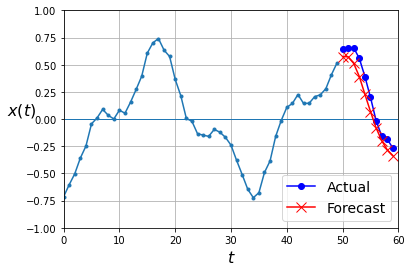

In [14]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [15]:


np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]



In [16]:

X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 0s 4ms/step


In [17]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.020955143

In [19]:
# predicting the next 10 values at once:


np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]


In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0516 - last_time_step_mse: 0.0414 - val_loss: 0.0432 - val_last_time_step_mse: 0.0323
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0379 - last_time_step_mse: 0.0259 - val_loss: 0.0348 - val_last_time_step_mse: 0.0217
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0313 - last_time_step_mse: 0.0190 - val_loss: 0.0300 - val_last_time_step_mse: 0.0176
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0282 - last_time_step_mse: 0.0156 - val_loss: 0.0250 - val_last_time_step_mse: 0.0121
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0251 - last_time_step_mse: 0.0125 - val_loss: 0.0234 - val_last_time_step_mse: 0.0115
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0246 - last_time_step_mse: 0.0125 - val_loss: 0.0260 - val_last_time_step_mse: 0.0159
Epoch 7/20
219/219 [===